*italicised text*# CycleGAN

## Setting up the input pipeline

Installing the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

dataset1, metadata1 = tfds.load('cycle_gan/vangogh2photo',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset1['trainB']
test_horses, test_zebras = dataset['testA'], dataset1['testB']
print(train_horses)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteN7E25Q/cycle_gan-trainA.tfrecord


  0%|          | 0/1067 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteN7E25Q/cycle_gan-trainB.tfrecord


  0%|          | 0/1334 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteN7E25Q/cycle_gan-testA.tfrecord


  0%|          | 0/120 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteN7E25Q/cycle_gan-testB.tfrecord


  0%|          | 0/140 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteB7OSYV/cycle_gan-trainA.tfrecord


  0%|          | 0/400 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteB7OSYV/cycle_gan-trainB.tfrecord


  0%|          | 0/6287 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteB7OSYV/cycle_gan-testA.tfrecord


  0%|          | 0/400 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0.incompleteB7OSYV/cycle_gan-testB.tfrecord


  0%|          | 0/751 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/vangogh2photo/2.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

print(sample_horse.shape)
print(sample_zebra.shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


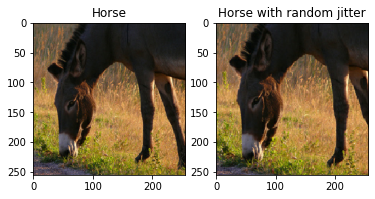

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

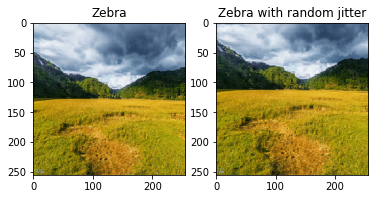

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Import the Pix2Pix models

In [ ]:
OUTPUT_CHANNELS = 3

'''
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

'''

class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset




def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)



'''
!pip install keras


# example of defining a 70x70 patchgan discriminator model
from keras.initializers import RandomNormal

from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
 
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model
 
# define image shape
image_shape = (256,256,3)
# create the model
#model = define_discriminator(image_shape)
# summarize the model
#model.summary()
# plot the model
#plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)



# example of defining a u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# example of defining a u-net encoder-decoder generator model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(1,256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
 
# define image shape
image_shape = (256,256,3)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)




generator_x = define_generator()
generator_y = define_generator()


discriminator_x = define_discriminator()
discriminator_y = define_discriminator()


'''

"\n!pip install keras\n\n\n# example of defining a 70x70 patchgan discriminator model\nfrom keras.initializers import RandomNormal\n\nfrom keras.models import Input\nfrom keras.layers import Conv2D\nfrom keras.layers import LeakyReLU\nfrom keras.layers import Activation\nfrom keras.layers import Concatenate\nfrom keras.layers import BatchNormalization\nfrom keras.utils.vis_utils import plot_model\n \n# define the discriminator model\ndef define_discriminator(image_shape):\n\t# weight initialization\n\tinit = RandomNormal(stddev=0.02)\n\t# source image input\n\tin_src_image = Input(shape=image_shape)\n\t# target image input\n\tin_target_image = Input(shape=image_shape)\n\t# concatenate images channel-wise\n\tmerged = Concatenate()([in_src_image, in_target_image])\n\t# C64\n\td = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)\n\td = LeakyReLU(alpha=0.2)(d)\n\t# C128\n\td = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)\n\t

'\nfor i in range(len(imgs)):\n  plt.subplot(2, 2, i+1)\n  plt.title(title[i])\n  if i % 2 == 0:\n    plt.imshow(imgs[i][0] * 0.5 + 0.5)\n  else:\n    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)\nplt.show()\n'

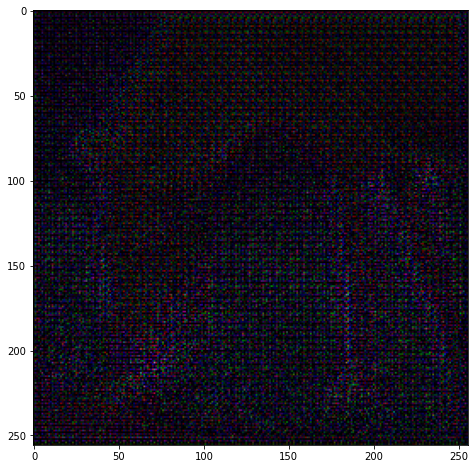

In [ ]:
#print(sample_horse)
#print(sample_zebra)
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8
plt.imshow(to_zebra[0])

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']
'''
for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()
'''

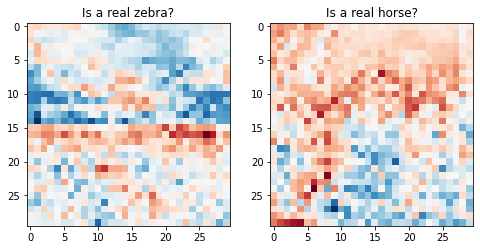

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training


In [ ]:
EPOCHS = 0

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
  print(prediction) 
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

tf.Tensor(
[[[[-0.08998495 -0.01225623  0.02074143]
   [ 0.01313322  0.03317126 -0.02306002]
   [-0.06410654  0.03013716 -0.04643909]
   ...
   [-0.02916022  0.12666629 -0.19174218]
   [-0.19056493 -0.27186224  0.14028393]
   [ 0.08826187 -0.02679447 -0.01436189]]

  [[ 0.1341889  -0.00243186 -0.03994611]
   [ 0.1344712  -0.03693786  0.18929785]
   [ 0.24864313 -0.03240805 -0.03788319]
   ...
   [ 0.16435617 -0.15154563  0.4434355 ]
   [ 0.22332646 -0.40713882 -0.12284947]
   [ 0.0608205  -0.07451446  0.08534004]]

  [[-0.11324326 -0.00575061  0.06562982]
   [ 0.08892792  0.21022838  0.02884555]
   [-0.28780583 -0.12111975  0.03570271]
   ...
   [-0.12858377  0.39262196 -0.11969133]
   [-0.610829   -0.2288317   0.5081116 ]
   [-0.05010955 -0.06605176 -0.1831458 ]]

  ...

  [[ 0.14729095  0.00408426 -0.03192783]
   [ 0.0167316   0.11297263  0.50833446]
   [ 0.21578717 -0.3963751   0.20842761]
   ...
   [ 0.03941492 -0.00862207  0.16191888]
   [ 0.11183635 -0.05908015 -0.00371337]
   [ 

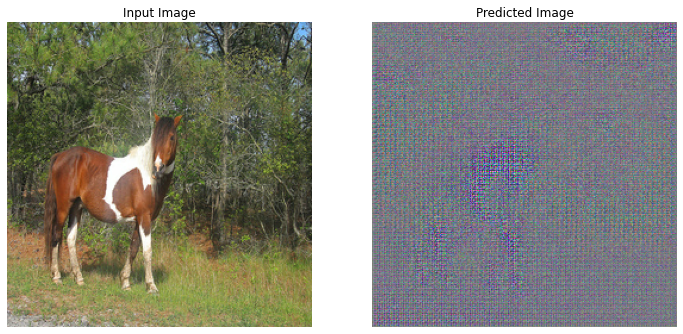

tf.Tensor(
[[[[-8.95435661e-02  4.54562809e-03  1.12588080e-02]
   [ 5.48990443e-02 -5.06210476e-02  4.19142880e-02]
   [-1.50751516e-01 -1.68873847e-01  4.98230234e-02]
   ...
   [ 2.82309502e-02  9.60434154e-02 -5.64061031e-02]
   [-7.43667111e-02 -1.79461256e-01  1.29478067e-01]
   [ 3.24047394e-02  4.44034487e-02 -5.49124181e-02]]

  [[ 1.44429505e-05 -3.80456224e-02 -1.52744725e-01]
   [-1.33382618e-01  1.25887424e-01  3.93425465e-01]
   [ 1.83094591e-01 -5.12347639e-01  2.22972527e-01]
   ...
   [ 1.42434418e-01 -1.46344200e-01  3.31172556e-01]
   [ 4.68258858e-02 -2.43928775e-01 -1.34433717e-01]
   [-2.05408838e-02 -5.66991083e-02  1.12798877e-01]]

  [[ 6.63488582e-02 -2.20801368e-01 -8.44246224e-02]
   [ 1.82518493e-02  2.09751114e-01 -7.04848394e-02]
   [-3.89261872e-01 -3.57223630e-01 -5.40630892e-02]
   ...
   [ 1.35878384e-01 -6.66170120e-02 -1.38649270e-01]
   [-2.86586612e-01 -2.38309830e-01  4.96836871e-01]
   [ 1.24471471e-01 -1.65281855e-02 -1.71841338e-01]]

  ...

 

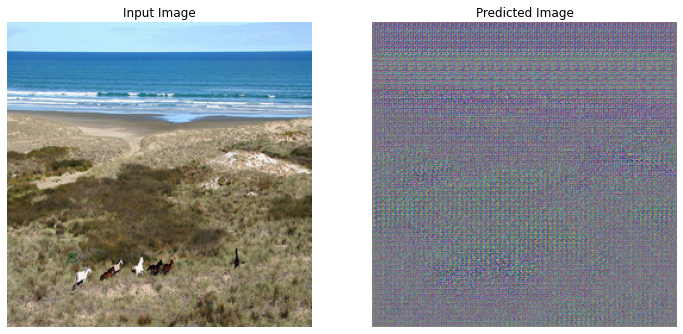

tf.Tensor(
[[[[-0.05812172 -0.01160426  0.01611744]
   [ 0.09816439 -0.13455743 -0.03263817]
   [-0.07272319 -0.05577945  0.00342751]
   ...
   [ 0.04994149 -0.15695071 -0.02831355]
   [-0.20502123 -0.20348611  0.05566622]
   [ 0.18368863  0.0538331  -0.03448432]]

  [[ 0.21813078 -0.04818819 -0.06114766]
   [ 0.02186964 -0.01125169  0.30265912]
   [ 0.22123855 -0.24226424  0.02352338]
   ...
   [ 0.1774586  -0.338793    0.45029965]
   [ 0.11593787 -0.10960995 -0.04398634]
   [ 0.08827139 -0.1261668   0.16921952]]

  [[-0.14199804  0.09086218 -0.02785908]
   [ 0.11160085  0.2717616  -0.04992402]
   [-0.47216728 -0.05267959  0.17016014]
   ...
   [-0.07987122 -0.02559441 -0.05807557]
   [-0.25444257  0.23274016  0.17408778]
   [-0.0431428   0.09303598 -0.19083463]]

  ...

  [[ 0.04310587  0.02049056  0.02557586]
   [-0.01983076 -0.07253034  0.30866468]
   [ 0.00700558 -0.15912282  0.08961275]
   ...
   [-0.05387382 -0.05923307  0.17257652]
   [ 0.09343896 -0.06655096  0.1068583 ]
   [ 

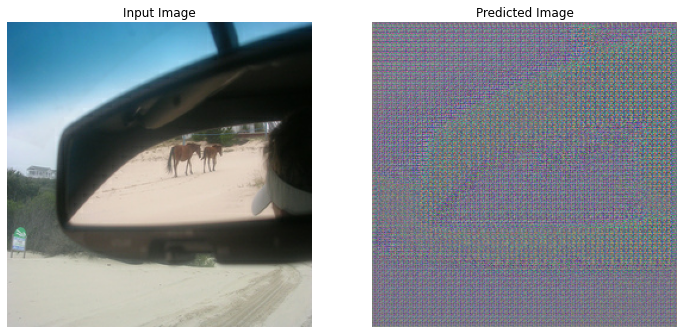

tf.Tensor(
[[[[-0.12733784 -0.01003994  0.00693314]
   [-0.01767676  0.03332394 -0.00403886]
   [-0.19451536  0.10070475 -0.12551452]
   ...
   [ 0.03663088 -0.20194595  0.02148895]
   [-0.32584265 -0.05751115 -0.00683516]
   [ 0.20168693 -0.06050884 -0.00172501]]

  [[ 0.22865918 -0.02078484 -0.06638344]
   [ 0.18904991 -0.20804557  0.04910303]
   [ 0.41974527 -0.08824023 -0.22739242]
   ...
   [ 0.2856632  -0.23323801  0.24345954]
   [ 0.1688776  -0.08767614  0.0209302 ]
   [-0.10440215 -0.19564591  0.23644824]]

  [[-0.1181317   0.01142202 -0.00985391]
   [ 0.09823848  0.23699917  0.08025307]
   [-0.5048907  -0.13404468  0.19467622]
   ...
   [ 0.08501787 -0.03325634  0.02691461]
   [-0.48553383  0.30883166  0.01321724]
   [-0.11705254  0.02951632 -0.20297518]]

  ...

  [[ 0.2542349  -0.21586125  0.1834318 ]
   [ 0.34516537  0.26202026  0.2120301 ]
   [ 0.2729667  -0.35073173  0.26945347]
   ...
   [ 0.1535025   0.18606241  0.16111434]
   [ 0.1567913  -0.3525485   0.00238669]
   [ 

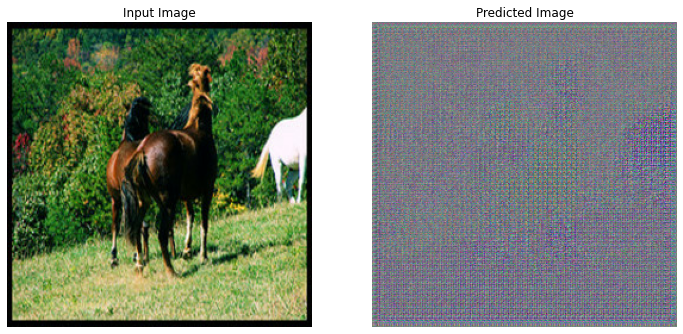

tf.Tensor(
[[[[-0.03752136  0.02059442  0.03298209]
   [ 0.03379947 -0.09755772  0.01317954]
   [-0.09362323 -0.15162465  0.05371816]
   ...
   [ 0.05755128  0.05083176 -0.068487  ]
   [-0.07208964 -0.14175548  0.1039828 ]
   [ 0.0245455   0.0333351  -0.04868975]]

  [[ 0.0495351  -0.02224126 -0.09908522]
   [-0.05029367  0.10533242  0.3592883 ]
   [ 0.16032185 -0.33573195  0.08498518]
   ...
   [ 0.08021735 -0.09581771  0.31009182]
   [ 0.0691369  -0.1724772  -0.13071927]
   [-0.00791086 -0.07980411  0.08470881]]

  [[ 0.01931911 -0.10496386 -0.1095299 ]
   [ 0.06262938  0.08045259 -0.05566074]
   [-0.24523023 -0.22285143  0.02352977]
   ...
   [ 0.06162078  0.00963796 -0.06811519]
   [-0.25838968 -0.17696148  0.3710354 ]
   [ 0.08419538 -0.01207962 -0.15159342]]

  ...

  [[ 0.12997091 -0.03022488  0.10069067]
   [ 0.03189106 -0.07473233  0.15163581]
   [ 0.27947584  0.0205595  -0.01672398]
   ...
   [ 0.0300812  -0.14858618  0.02229862]
   [ 0.11803187 -0.07705658  0.08895103]
   [ 

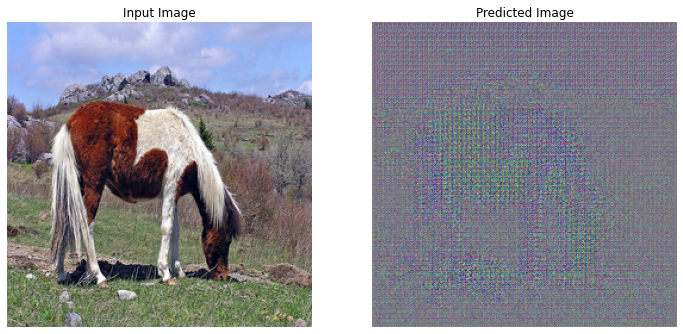

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

## Encryption Model

Generate an internal encryption key to encrypt all the data used in the model.


In [ ]:
!pip install cryptography

     |████████████████████████████████| 3.6 MB 5.2 MB/s 


In [ ]:
from cryptography.fernet import Fernet

key = Fernet.generate_key()
fernet = Fernet(key)
def encrypt_msg(msg):
  return (fernet.encrypt(msg)).decode()

def decrypt_msg(msg):
  return fernet.decrypt(msg.encode())

Generate a public key by hashing a random permutation of array.


In [ ]:
import numpy as np
import pickle

def getMatrixFromTensor(prediction):
  return (prediction.numpy()[0])

def generate_publicKey():
  arr = np.random.permutation(65536)
  stringsd = pickle.dumps(arr)
  return encrypt_msg(stringsd)

def generate_privateKey(prediction):
  stringsd = pickle.dumps(getMatrixFromTensor(prediction))
  return encrypt_msg(stringsd)

def getData_fromKey(some_key):
  s123 = decrypt_msg(some_key)
  return pickle.loads(s123)


This function is used to take xor of floating point numbers

In [ ]:
import struct, math

def fxor(a, b):
  rtrn = []
  a = struct.pack('d', a)
  b = struct.pack('d', b)
  for ba, bb in zip(a, b):
    rtrn.append(ba ^ bb)

  return struct.unpack('d', bytes(rtrn))[0]


Encryptor_Decryptor_function

In [ ]:
def encryptor_decryptor_function(input_matrix,pv_matrix,location_matrix):
  output_mat = np.zeros((256,256,3))
  for i in range(0,65536):
    x = location_matrix[i]

    input_matrix_row = i // 256
    input_matrix_column = i % 256

    pv_matrix_row = x // 256
    pv_matrix_column = x % 256

    for j in range(0,3):
      output_mat[input_matrix_row,input_matrix_column,j] = fxor(input_matrix[input_matrix_row,input_matrix_column,j],pv_matrix[pv_matrix_row,pv_matrix_column,j])
  
  return output_mat


In [ ]:
def encrypt_image(image):
  prediction_tensor = generator_g(image)
  input_img_matrix = getMatrixFromTensor(image)

  public_Key = generate_publicKey()
  private_Key = generate_privateKey(prediction_tensor)

  xorLocationMatrix = getData_fromKey(public_Key)
  privateKeyMatrix = getData_fromKey(private_Key)

  out_mat = encryptor_decryptor_function(input_img_matrix,privateKeyMatrix,xorLocationMatrix)

  return (out_mat,public_Key,private_Key)

def decrypt_image(image,pb_Key,pv_Key):
  xorLocationMatrix = getData_fromKey(pb_Key)
  privateKeyMatrix = getData_fromKey(pv_Key)

  out_mat = encryptor_decryptor_function(image,privateKeyMatrix,xorLocationMatrix)
  return out_mat

def show_image(image,title,sbplot):
  plt.subplot(sbplot)
  plt.imshow(image*0.5 + 0.5, interpolation='nearest')
  plt.title(title)

def code_runner():
  print("")
  print("-- Start --")
  print("")

  plt.figure(figsize=(12, 12))

  input_image = next(iter(train_horses))
  
  show_image(input_image[0],"Original Image",131)

  output_temp = encrypt_image(input_image)

  encrypted_image = output_temp[0]
  public_key = output_temp[1]
  private_key = output_temp[2]

  show_image(encrypted_image,"Encrypted Image",132)

  decrypted_image = decrypt_image(encrypted_image,public_key,private_key)

  show_image(decrypted_image,"Decrypted Image",133)

  plt.show()
  file1 = open("public_key.txt","w")
  file1.write(public_key)
  file1.close()

  file2 = open("private_key.txt","w")
  file2.write(public_key)
  file2.close()

  print("")
  print("-- End --")
  print("")


-- Start --



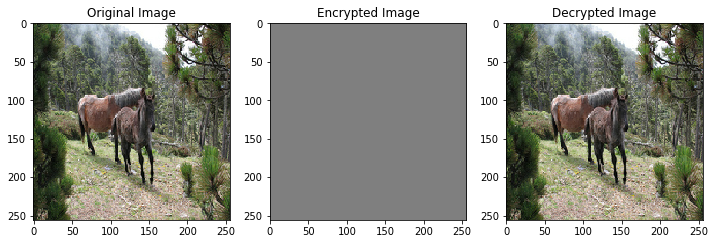


-- End --


-- Start --



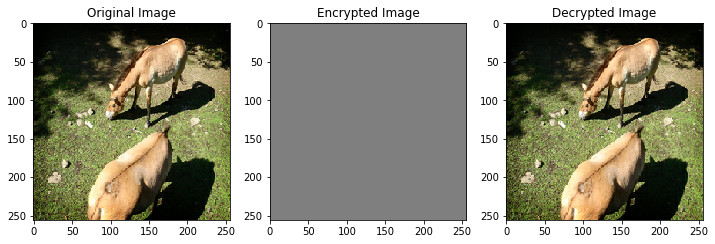


-- End --


-- Start --



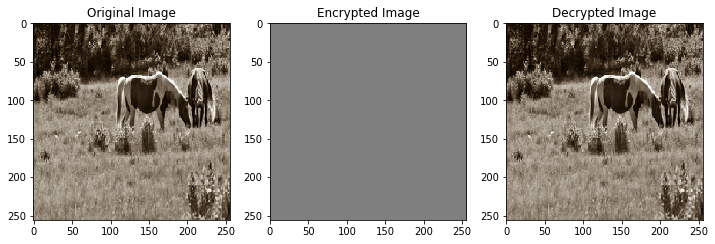


-- End --


-- Start --



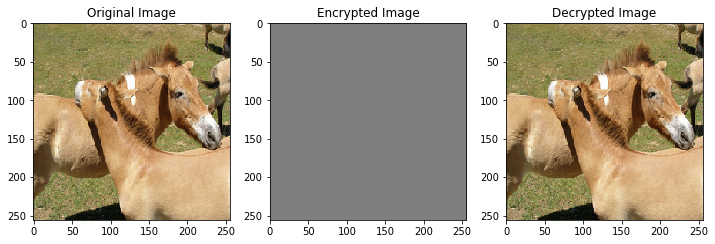


-- End --


-- Start --



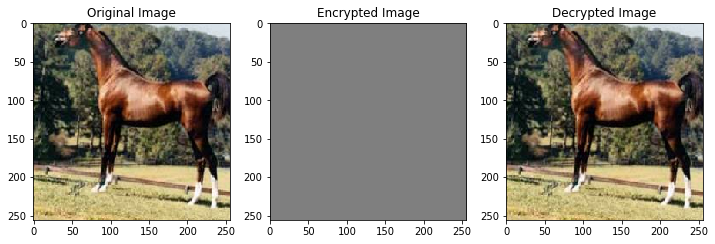


-- End --



In [ ]:
for i in range(0,5):
  code_runner()